In [1]:
import os
import sys
from tqdm import tqdm_notebook as tqdm

import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from matplotlib import pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from transformers import BertTokenizer, BertModel, BertForMaskedLM

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# re-load functions
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%config InlineBackend.figure_formats = {'png', 'retina'}

In [3]:
DEVICE = 'cuda'

## load csvs

In [4]:
ls ../../mnt/inputs/origin

google-quest-challenge.zip  sample_submission.csv  test.csv  train.csv


In [5]:
trn_df = pd.read_csv('../../mnt/inputs/origin/train.csv')
display(trn_df.shape, trn_df.head())
tst_df = pd.read_csv('../../mnt/inputs/origin/test.csv')
display(tst_df.shape, tst_df.head())
sub_df = pd.read_csv('../../mnt/inputs/origin/sample_submission.csv')
display(sub_df.shape, sub_df.head())

(6079, 41)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


(476, 11)

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host
0,39,Will leaving corpses lying around upset my pri...,I see questions/information online about how t...,Dylan,https://gaming.stackexchange.com/users/64471,There is no consequence for leaving corpses an...,Nelson868,https://gaming.stackexchange.com/users/97324,http://gaming.stackexchange.com/questions/1979...,CULTURE,gaming.stackexchange.com
1,46,Url link to feature image in the portfolio,I am new to Wordpress. i have issue with Featu...,Anu,https://wordpress.stackexchange.com/users/72927,I think it is possible with custom fields.\n\n...,Irina,https://wordpress.stackexchange.com/users/27233,http://wordpress.stackexchange.com/questions/1...,TECHNOLOGY,wordpress.stackexchange.com
2,70,"Is accuracy, recoil or bullet spread affected ...","To experiment I started a bot game, toggled in...",Konsta,https://gaming.stackexchange.com/users/37545,You do not have armour in the screenshots. Thi...,Damon Smithies,https://gaming.stackexchange.com/users/70641,http://gaming.stackexchange.com/questions/2154...,CULTURE,gaming.stackexchange.com
3,132,Suddenly got an I/O error from my external HDD,I have used my Raspberry Pi as a torrent-serve...,robbannn,https://raspberrypi.stackexchange.com/users/17341,Your Western Digital hard drive is disappearin...,HeatfanJohn,https://raspberrypi.stackexchange.com/users/1311,http://raspberrypi.stackexchange.com/questions...,TECHNOLOGY,raspberrypi.stackexchange.com
4,200,Passenger Name - Flight Booking Passenger only...,I have bought Delhi-London return flights for ...,Amit,https://travel.stackexchange.com/users/29089,I called two persons who work for Saudia (tick...,Nean Der Thal,https://travel.stackexchange.com/users/10051,http://travel.stackexchange.com/questions/4704...,CULTURE,travel.stackexchange.com


(476, 31)

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308,0.00308
1,46,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448,0.00448
2,70,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673,0.00673
3,132,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401,0.01401
4,200,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074,0.02074


================ question_title ================


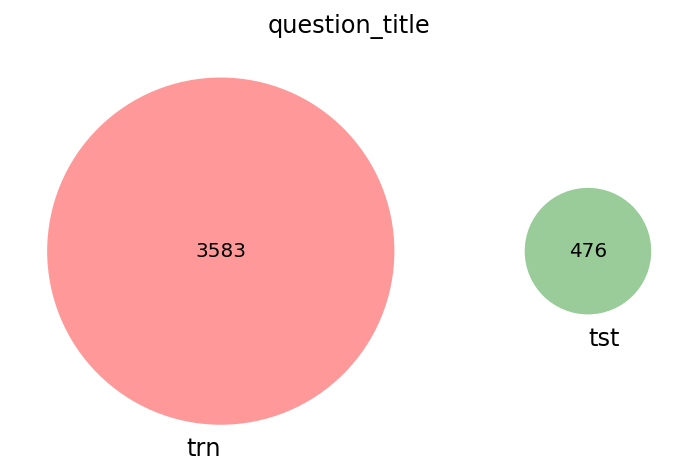

================ question_body ================


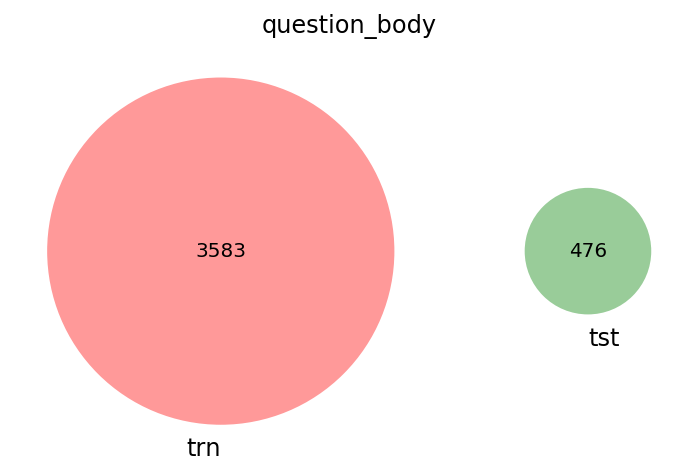

================ question_user_name ================


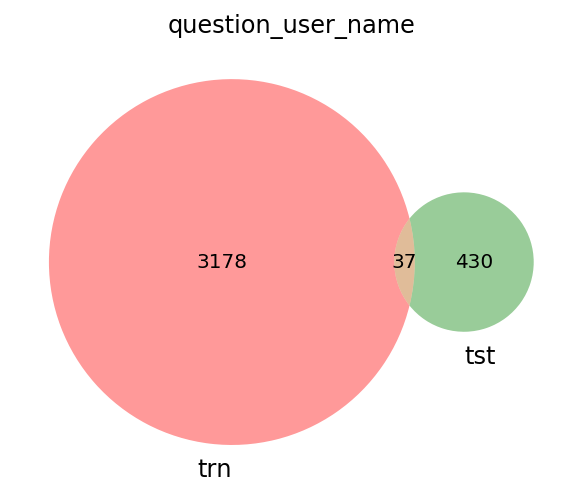

================ question_user_page ================


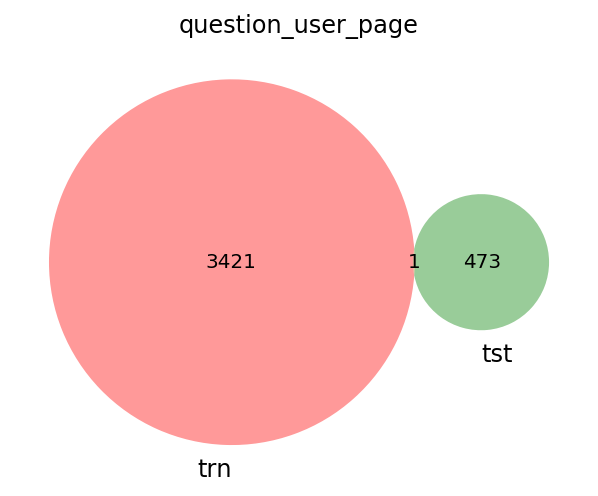

================ answer ================


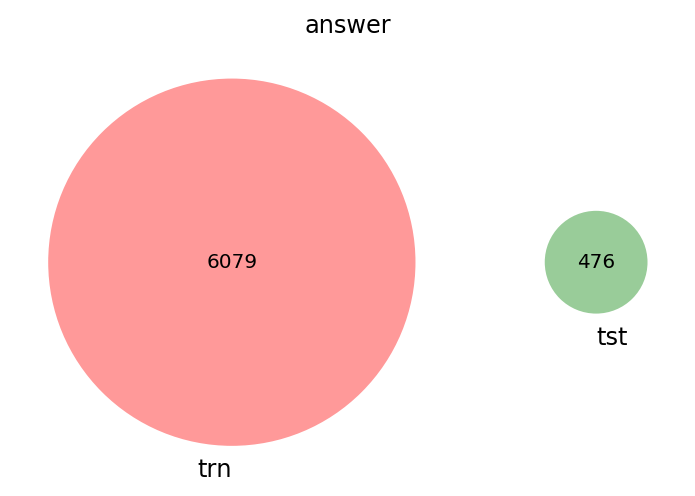

================ answer_user_name ================


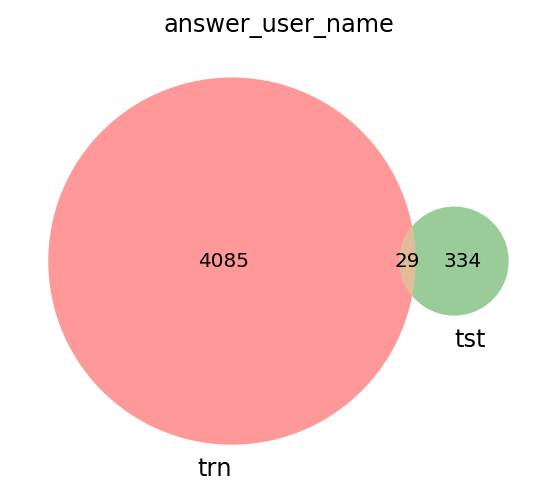

================ answer_user_page ================


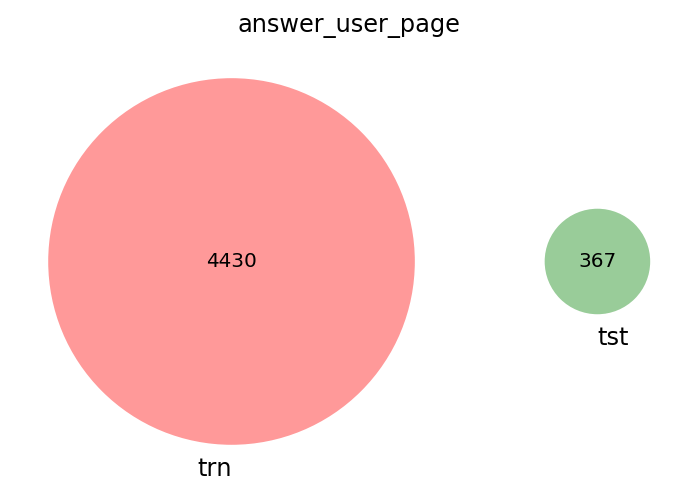

================ url ================


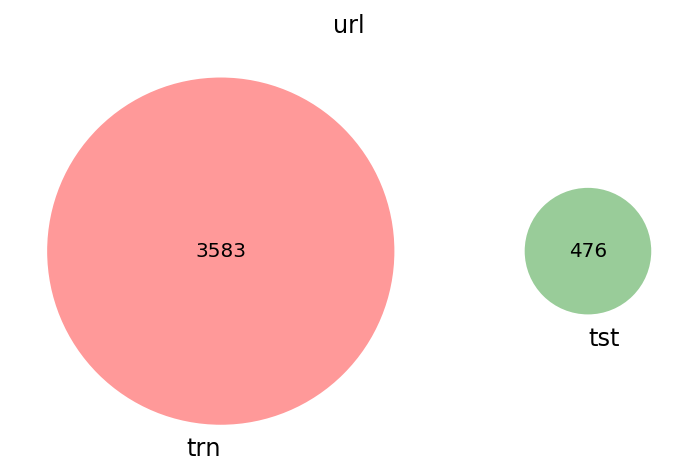

================ category ================


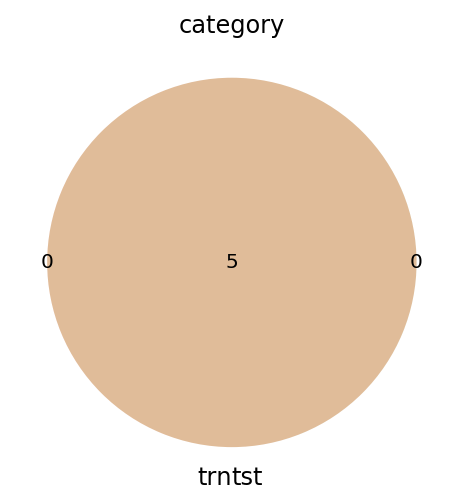

In [171]:
import matplotlib_venn

for col in trn_df.iloc[:, 1:10].columns:
    print(f'================ {col} ================')
    matplotlib_venn.venn2([set(trn_df[col]), set(tst_df[col])], set_labels=('trn', 'tst'))
    plt.title(col)
    plt.show()

In [163]:
trn_df.question_user_name.value_counts()

Mike            15
Alex            14
Shane           12
David           11
Eric            11
                ..
jonderry         1
WonderingJew     1
Bakhtiyor        1
jaypabs          1
user3599444      1
Name: question_user_name, Length: 3215, dtype: int64

In [162]:
trn_df.question_title.value_counts()

What is the best introductory Bayesian statistics textbook?                         12
What does mathematics have to do with programming?                                  11
Important non-technical course for programmers?                                     11
How to prevent the "Too awesome to use" syndrome                                     9
Another instructor is pushing me out of the classroom right after my class ends      7
                                                                                    ..
How to interpret a Current Value into a PWM signal percentage?                       1
Setting up form table checkboxes                                                     1
How can I create and retrieve default billing address programatically?               1
Quasi-isometric embeddings of the mapping class group into the Teichmuller space     1
How to change semitransparent part                                                   1
Name: question_title, Length: 3583, dtype: 

In [161]:
trn_df.question_body.value_counts()

Which is the best introductory textbook for Bayesian statistics?\n\nOne book per answer, please.\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## まずは動かしながら学んで見る

#### preprocessing functions
イメージとしては batch 内で padding する感じかな？

#### 流れイメージ
[basic notebook](https://www.kaggle.com/akensert/bert-base-tf2-0-minimalistic)を見ながら以下の処理を実装する

1. preprocess
    - 
    - 
1. transforrmer 入りの model を作る
1. 

#### 知見
- hagginface の tokenizer は 2 sentences までしか support してないので、これをハックするか title, q, a でなく title + q, a でやるべき
- 

In [52]:
MAX_SEQUENCE_LENGTH = 512

In [9]:
# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize input
# text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
text = "[CLS] Who was Jim Henson ? [SEP] Jim Henson was a puppeteer [SEP]"
tokenized_text = tokenizer.tokenize(text)
print(tokenized_text )

# Mask a token that we will try to predict back with `BertForMaskedLM`
masked_index = 8
tokenized_text[masked_index] = '[MASK]'
assert tokenized_text == ['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']
print(tokenized_text)

# Convert token to vocabulary indices
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
# Define sentence A and B indices associated to 1st and 2nd sentences (see paper)
segments_ids = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])
print(tokens_tensor)
print(segments_tensors)

['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', 'henson', 'was', 'a', 'puppet', '##eer', '[SEP]']
['[CLS]', 'who', 'was', 'jim', 'henson', '?', '[SEP]', 'jim', '[MASK]', 'was', 'a', 'puppet', '##eer', '[SEP]']
tensor([[  101,  2040,  2001,  3958, 27227,  1029,   102,  3958,   103,  2001,
          1037, 13997, 11510,   102]])
tensor([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]])


In [11]:
dir(tokenizer)

['SPECIAL_TOKENS_ATTRIBUTES',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_additional_special_tokens',
 '_bos_token',
 '_cls_token',
 '_convert_id_to_token',
 '_convert_token_to_id',
 '_convert_token_to_id_with_added_voc',
 '_eos_token',
 '_from_pretrained',
 '_mask_token',
 '_pad_token',
 '_pad_token_type_id',
 '_sep_token',
 '_tokenize',
 '_unk_token',
 'add_special_tokens',
 'add_tokens',
 'added_tokens_decoder',
 'added_tokens_encoder',
 'additional_special_tokens',
 'additional_special_tokens_ids',
 'all_special_ids',
 'all_special_tokens',
 'basic_tokenizer',
 'batch_encode_plus',
 'bos_token',
 'bos_token_id',
 'build_inputs_with_special_tokens'

In [20]:
print(tokenizer.encode("Here is some text to encode", add_special_tokens=True))
print(tokenizer.encode("Here is some text to encode", add_special_tokens=False))

[101, 2182, 2003, 2070, 3793, 2000, 4372, 16044, 102]
[2182, 2003, 2070, 3793, 2000, 4372, 16044]


In [33]:
print(tokenizer.decode(tokenizer.encode("[CLS] Here is some text to encode. Temp index.", add_special_tokens=False)))

[CLS] here is some text to encode. temp index.


In [ ]:
tokenizer.decode

In [36]:
print(tokenizer.encode("[CLS] Here is some text to encode. Temp index.", add_special_tokens=False))

[101, 2182, 2003, 2070, 3793, 2000, 4372, 16044, 1012, 8915, 8737, 5950, 1012]


In [35]:
print(tokenizer.encode("[CLS] Here is some text to encode. [SEP] Temp index.", add_special_tokens=False))

[101, 2182, 2003, 2070, 3793, 2000, 4372, 16044, 1012, 102, 8915, 8737, 5950, 1012]


In [42]:
print(tokenizer.decode(tokenizer.encode("[CLS] Here is some text to encode. [SEP] Temp index.", add_special_tokens=False), skip_special_tokens=True,  clean_up_tokenization_spaces=True))

here is some text to encode. temp index.


In [44]:
print(tokenizer.decode(tokenizer.encode("[CLS] Here is some text to encode. [SEP] Temp index.", add_special_tokens=True), skip_special_tokens=False,  clean_up_tokenization_spaces=True))

[CLS] [CLS] here is some text to encode. [SEP] temp index. [SEP]


In [51]:
tokenizer.decode(tokenizer.encode('Here is some text to encode.', 'Temp index.', add_special_tokens=True))

'[CLS] here is some text to encode. [SEP] temp index. [SEP]'

In [53]:
tokenizer.decode(tokenizer.encode(
    text='Here is some text to encode.',
    text_pair='Temp index.',
    add_special_tokens=True,
    max_length=MAX_SEQUENCE_LENGTH,
    pad_to_max_length=True
))

'[CLS] here is some text to encode. [SEP] temp index. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [10]:
model = BertModel.from_pretrained('bert-base-uncased')

In [81]:
encoded_inputs = tokenizer.encode(
    text='Here is some text to encode.',
    text_pair='Temp index.',
    add_special_tokens=True,
    #max_length=MAX_SEQUENCE_LENGTH,
    max_length=24,
    pad_to_max_length=True,
    return_tensors='pt'
)
with torch.no_grad():
    # 0 is the token id for [PAD]
    res = model(encoded_inputs, attention_mask=encoded_inputs==0, )

In [82]:
len(res)

2

In [69]:
# 1: batchsize
# 24: seq len
# 768: embedding size : おそらく hidden states に
res[0].shape

torch.Size([1, 24, 768])

In [70]:
res[1].shape

torch.Size([1, 768])

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
    ):

        outputs = (sequence_output, pooled_output,) + encoder_outputs[
            1:
        ]  # add hidden_states and attentions if they are here
        return outputs  # sequence_output, pooled_output, (hidden_states), (attentions)

[ここ](https://github.com/huggingface/transformers/blob/ce50305e5b8c8748b81b0c8f5539a337b6a995b9/src/transformers/modeling_bert.py#L181-L183)を見る感じ、positional_embedding は None で良さそう

In [85]:
# 
tokenizer.encode_plus(
    text='Here is some text to encode.',
    text_pair='Temp index.',
    add_special_tokens=True,
    #max_length=MAX_SEQUENCE_LENGTH,
    max_length=24,
    pad_to_max_length=True,
    return_tensors='pt',
    return_token_type_ids=True,
    return_attention_mask=True,
    return_overflowing_tokens=True,
)

{'input_ids': tensor([[  101,  2182,  2003,  2070,  3793,  2000,  4372, 16044,  1012,   102,
           8915,  8737,  5950,  1012,   102,     0,     0,     0,     0,     0,
              0,     0,     0,     0]]),
 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

## なんとなくわかってきたので、とりあえず BERT で学習 pipeline 作ってみる

In [86]:
trn_df.head()

,qa_id,question_title,question_body,question_user_name,question_user_page,answer,answer_user_name,answer_user_page,url,category,host,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,question_not_really_a_question,question_opinion_seeking,question_type_choice,question_type_compare,question_type_consequence,question_type_definition,question_type_entity,question_type_instructions,question_type_procedure,question_type_reason_explanation,question_type_spelling,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,0,What am I losing when using extension tubes in...,After playing around with macro photography on...,ysap,https://photo.stackexchange.com/users/1024,"I just got extension tubes, so here's the skin...",rfusca,https://photo.stackexchange.com/users/1917,http://photo.stackexchange.com/questions/9169/...,LIFE_ARTS,photo.stackexchange.com,1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,1.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,0.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,russellpierce,https://rpg.stackexchange.com/users/8774,It might be helpful to look into the definitio...,Erik Schmidt,https://rpg.stackexchange.com/users/1871,http://rpg.stackexchange.com/questions/47820/w...,CULTURE,rpg.stackexchange.com,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,0.444444,0.666667,0.0,0.000000,0.666667,0.666667,0.0,0.333333,0.0,0.0,0.000000,0.333333,0.0,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Joe Baker,https://electronics.stackexchange.com/users/10157,Do you even need grooves? We make several pro...,Dwayne Reid,https://electronics.stackexchange.com/users/64754,http://electronics.stackexchange.com/questions...,SCIENCE,electronics.stackexchange.com,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.444444,0.333333,0.0,0.333333,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.333333,0.333333,0.0,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...",Scimonster,https://judaism.stackexchange.com/users/5151,"Sending an ""affidavit"" it is a dispute between...",Y e z,https://judaism.stackexchange.com/users/4794,http://judaism.stackexchange.com/questions/551...,CULTURE,judaism.stackexchange.com,0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,0.444444,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,5,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,leigero,https://graphicdesign.stackexchange.com/users/...,Check out Image Trace in Adobe Illustrator. \n...,q2ra,https://graphicdesign.stackexchange.com/users/...,http://graphicdesign.stackexchange.com/questio...,LIFE_ARTS,graphicdesign.stackexchange.com,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,1.0,0.000000,1.000000,0.0,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


In [129]:
TBSEP = '[TBSEP]'

def _preprocess_text_row(row, tokenizer):
    qa_id = row.qa_id
    title = row.question_title
    body = row.question_body
    answer  = row.answer
    
    encoded_texts_dict = tokenizer.encode_plus(
        text=title+f' {TBSEP} '+body,
        text_pair=answer,
        add_special_tokens=True,
        max_length=MAX_SEQUENCE_LENGTH,
        pad_to_max_length=True,
        return_tensors='pt',
        return_token_type_ids=True,
        return_attention_mask=True,
        return_overflowing_tokens=True,
    )
    encoded_texts_dict['qa_id'] = qa_id
    return encoded_texts_dict
    
    
def preprocess_texts(df, tokenizer):
    tokenizer.add_special_tokens({'additional_special_tokens': [TBSEP]})
    
    res = []
    for i, row in tqdm(list(df.iterrows())):
        res.append(_preprocess_text_row(row, tokenizer))

    return res, tokenizer

In [130]:
res, res_tokenizer = preprocess_texts(trn_df, tokenizer)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [133]:
res_trn_df = pd.DataFrame(res)
res_trn_df.head()

,input_ids,token_type_ids,attention_mask,qa_id,overflowing_tokens,num_truncated_tokens
0,"[[tensor(101), tensor(2054), tensor(2572), ten...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",0,NaN,NaN
1,"[[tensor(101), tensor(2054), tensor(2003), ten...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",1,NaN,NaN
2,"[[tensor(101), tensor(4555), tensor(4013), ten...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",2,NaN,NaN
3,"[[tensor(101), tensor(2064), tensor(2019), ten...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",3,[],245.0
4,"[[tensor(101), tensor(2129), tensor(2079), ten...","[[tensor(0), tensor(0), tensor(0), tensor(0), ...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",5,NaN,NaN


#### dataset class を定義

In [6]:
from torch.utils.data import Dataset

class QUESTDataset(Dataset):
    def __init__(self, mode, qa_ids, augment, pretrained_model_name_or_path,
                 data_path='../../mnt/inputs/origin/', TBSEP = '[TBSEP]',
                 MAX_SEQUENCE_LENGTH=512, logger=None):
        '''
        '''
        self.mode = mode
        self.augment = augment
        self.len = None
        self.TBSEP = TBSEP
        self.MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH
        self.logger = logger

        if mode == "test":
            df = pd.read_csv(f'{data_path}/test.csv')
            # dummy label
            self.labels = [[-1] * 30] * len(qa_ids)
        else:  # train or valid
            df = pd.read_csv(f'{data_path}/train.csv').set_index('qa_id').loc[qa_ids].reset_index()
            self.labels = df.iloc[:, 11:]

        tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path)
        res, res_tokenizer = self._preprocess_texts(df, tokenizer)
        self.tokenizer = res_tokenizer
        self.prep_df = df.merge(pd.DataFrame(res), on='qa_id', how='left')

    def __len__(self):
            return len(self.prep_df)

    def __getitem__(self, idx):
        idx_row = self.prep_df.iloc[idx]
        input_ids = idx_row['input_ids'].squeeze()
        token_type_ids = idx_row['token_type_ids'].squeeze()
        attention_mask = idx_row['attention_mask'].squeeze()
        qa_id = idx_row['qa_id'].squeeze()
        
        labels = self.labels.iloc[idx].values
        return qa_id, input_ids, attention_mask, token_type_ids, labels

    def __preprocess_text_row(self, row, tokenizer):
        qa_id = row.qa_id
        title = row.question_title
        body = row.question_body
        answer  = row.answer

        encoded_texts_dict = tokenizer.encode_plus(
            text=title + f' {self.TBSEP} ' + body,
            text_pair=answer,
            add_special_tokens=True,
            max_length=self.MAX_SEQUENCE_LENGTH,
            pad_to_max_length=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
            return_overflowing_tokens=True,
        )
        encoded_texts_dict['qa_id'] = qa_id
        return encoded_texts_dict

    def _preprocess_texts(self, df, tokenizer):
        '''
        could be multi-processed if you need speeding up

        '''
        tokenizer.add_special_tokens({'additional_special_tokens': [self.TBSEP]})

        res = []
        for i, row in tqdm(list(df.iterrows())):
            res.append(self.__preprocess_text_row(row, tokenizer))

        return res, tokenizer

In [24]:
class BertModelBinaryMultiLabelClassifier(nn.Module):
#class BertModelBinaryMultiLabelClassifier():
    def __init__(self, fobj, num_labels, pretrained_model_name_or_path=None):
        super(BertModelBinaryMultiLabelClassifier, self).__init__()
        if pretrained_model_name_or_path:
            self.model = BertModel.from_pretrained(pretrained_model_name_or_path)
        else:
            raise NotImplementedError
        self.fobj = fobj
        self.num_labels = num_labels
        self.dropout = nn.Dropout(0.2)
        self.classifier = nn.Linear(self.model.pooler.dense.out_features, num_labels)
        #self.pooling_fc = nn.Linear(self.model.pooler.dense.out_features, num_labels)
        self.add_module('fc_output', self.classifier)
        #self.add_module('pooling_fc', self.pooling_fc)
    
    def forward(self, input_ids=None, labels=None, attention_mask=None, token_type_ids=None, position_ids=None,
                         head_mask=None, inputs_embeds=None, encoder_hidden_states=None, encoder_attention_mask=None):
        outputs = self.model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids,
                                             position_ids=position_ids, head_mask=head_mask, inputs_embeds=inputs_embeds,
                                             encoder_hidden_states=encoder_hidden_states, encoder_attention_mask=encoder_attention_mask)
        # pooled_output = outputs[1]
        pooled_output = torch.mean(outputs[0], dim=1)

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                # loss = loss_fct(logits.view(-1), labels.view(-1))
                loss = loss_fct(logits, labels)
            else:
                loss = self.fobj(logits, labels)
            outputs = (loss,) + outputs
        else:
            outputs = (None,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

In [25]:
def soft_binary_cross_entropy(pred, soft_targets):
    L = -torch.sum((soft_targets * torch.log(nn.functional.sigmoid(pred)) + (1. - soft_targets) * torch.log(nn.functional.sigmoid(1. - pred))), 1)
    return torch.mean(L)
#    return torch.mean(torch.sum(- soft_targets * nn.functional.logsigmoid(pred), 1)
#                                  + torch.sum(- (1. - soft_targets) * nn.functional.logsigmoid(pred), 1))

def compute_spearmanr(trues, preds):
    rhos = []
    for col_trues, col_pred in zip(trues.T, preds.T):
        rhos.append(spearmanr(col_trues, col_pred + np.random.normal(0, 1e-7, col_pred.shape[0])).correlation)
    return np.mean(rhos)

In [26]:
compute_spearmanr(trn_df.iloc[:, 11:].values, trn_df.iloc[:, 11:].values)

0.7743858733731235

In [27]:
def train_one_epoch(model, fobj, optimizer, loader):
    model.train()
    
    running_loss = 0
    for (qa_id, input_ids, attention_mask, token_type_ids, labels) in tqdm(loader):
        # send them to DEVICE
        input_ids, attention_mask, token_type_ids, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), token_type_ids.to(DEVICE), labels.to(DEVICE)

        # forward
        outputs = model(
            input_ids=input_ids,
            labels=labels,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )
        loss, logits = outputs[0], outputs[1]
        
        # backword and update
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        # store loss to culc epoch mean
        running_loss += loss

    loss_mean = running_loss / len(loader)
        
    return loss_mean

def test(model, loader, tta=False):
    model.eval()

    with torch.no_grad():
        y_preds, y_trues, qa_ids = [], [], []

        running_loss = 0
        for (qa_id, input_ids, attention_mask, token_type_ids, labels) in tqdm(loader):
            # send them to DEVICE
            input_ids, attention_mask, token_type_ids, labels = input_ids.to(DEVICE), attention_mask.to(DEVICE), token_type_ids.to(DEVICE), labels.to(DEVICE)

            # forward
            outputs = model(
                input_ids=input_ids,
                labels=labels,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids,
            )
            loss, logits = outputs[0], outputs[1]

            running_loss += loss
            
            y_preds.append(nn.functional.sigmoid(logits))
            y_trues.append(labels)
            qa_ids.append(qa_id)

        loss_mean = running_loss / len(loader)

        y_preds = torch.cat(y_preds).to('cpu').numpy()
        y_trues = torch.cat(y_trues).to('cpu').numpy()
        qa_ids = torch.cat(qa_ids).to('cpu').numpy()
        
        metric = compute_spearmanr(y_trues, y_preds)
        
    return loss_mean, metric, y_preds, y_trues, qa_ids

In [28]:
def save_checkpoint(exp_id, model, optimizer, scheduler,
                                     histories, val_y_preds, val_y_trues, val_qa_ids,
                                     current_fold, current_epoch, val_loss, val_metric):
    if not os.path.exists(f'../mnt/checkpoints/{exp_id}'):
        os.makedirs(f'../mnt/checkpoints/{exp_id}')
    # pth means pytorch
    cp_filename = f'../mnt/checkpoints/{exp_id}/' \
        f'fold_{current_fold}_epoch_{current_epoch}_{val_loss:.5f}_{val_metric:.5f}_checkpoint.pth'
    cp_dict = {
        'current_fold': current_fold,
        'current_epoch': current_epoch,
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'histories': histories,
    }
    print(f'now saving checkpoint to {cp_filename} ...')
    torch.save(cp_dict, cp_filename)

In [ ]:
#%debug
from torch.utils.data import DataLoader

# train してみる
PRETRAIN = 'bert-base-uncased'
BATCH_SIZE = 6
MAX_EPOCH = 5

# split
from sklearn.model_selection import GroupKFold
gkf = GroupKFold(n_splits=5).split(X=trn_df.question_body, groups=trn_df.question_body)

#tst_dataset = QUESTDataset(mode='test', qa_ids=tst_df.qa_id, augment=[], pretrained_model_name_or_path=PRETRAIN, data_path='../../mnt/inputs/origin/')
#tst_sampler = torch.utils.data.sampler.RandomSampler(data_source=tst_dataset)

histories = {
    'trn_loss': [],
    'val_loss': [],
    'val_metric': [],
}
for fold, (trn_idx, val_idx) in enumerate(gkf):
    trn_qa_ids = trn_df.iloc[trn_idx].qa_id
    val_qa_ids = trn_df.iloc[val_idx].qa_id
    
    trn_dataset = QUESTDataset(mode='train', qa_ids=trn_qa_ids, augment=[], pretrained_model_name_or_path=PRETRAIN, data_path='../../mnt/inputs/origin/')
    trn_sampler = torch.utils.data.sampler.RandomSampler(data_source=trn_dataset)
    trn_loader = DataLoader(trn_dataset, batch_size=BATCH_SIZE, sampler=trn_sampler, num_workers=os.cpu_count(),
                                                worker_init_fn=lambda x: np.random.seed(), drop_last=True, pin_memory=True)
    val_dataset = QUESTDataset(mode='valid', qa_ids=val_qa_ids, augment=[], pretrained_model_name_or_path='bert-base-uncased', data_path='../../mnt/inputs/origin/')
    val_sampler = torch.utils.data.sampler.RandomSampler(data_source=val_dataset)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=os.cpu_count(),
                                                worker_init_fn=lambda x: np.random.seed(), drop_last=False, pin_memory=True)
    
    fobj = soft_binary_cross_entropy
    model = BertModelBinaryMultiLabelClassifier(fobj=fobj, num_labels=30, pretrained_model_name_or_path=PRETRAIN).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=3e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCH, eta_min=1e-5)
    
    for epoch in tqdm(list(range(MAX_EPOCH))):
        trn_loss = train_one_epoch(model, fobj, optimizer, trn_loader)
        val_loss, val_metric, val_y_preds, val_y_trues, val_qa_ids = test(model, val_loader)
        
        scheduler.step()
        histories['trn_loss'].append(trn_loss)
        histories['val_loss'].append(val_loss)
        histories['val_metric'].append(val_metric)
        print(trn_loss.detach().to('cpu').numpy(), val_loss.detach().to('cpu').numpy(), val_metric)
        save_checkpoint('e001', model, optimizer, scheduler, histories, val_y_preds, val_y_trues, val_qa_ids, fold, epoch, val_loss, val_metric)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:70: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



8.51158358227007 8.105369786431947 0.34257187057519173
now saving checkpoint to ../mnt/checkpoints/e001/epoch_0_8.10537_0.34257_checkpoint.pth ...



7.896386384935508 8.024111966137875 0.37760201692330947
now saving checkpoint to ../mnt/checkpoints/e001/epoch_1_8.02411_0.37760_checkpoint.pth ...



7.583152007591294 7.928560549278761 0.38478200632393716
now saving checkpoint to ../mnt/checkpoints/e001/epoch_2_7.92856_0.38478_checkpoint.pth ...



7.299532739255683 7.965020376492211 0.3930036144513329
now saving checkpoint to ../mnt/checkpoints/e001/epoch_3_7.96502_0.39300_checkpoint.pth ...



7.05209203267298 8.03277894544517 0.3888286036787537
now saving checkpoint to ../mnt/checkpoints/e001/epoch_4_8.03278_0.38883_checkpoint.pth ...




8.60513880666712 8.214617829750468 0.32650285258239536
now saving checkpoint to ../mnt/checkpoints/e001/epoch_0_8.21462_0.32650_checkpoint.pth ...



7.957613332845002 7.982615675185797 0.3566180677522779
now saving checkpoint to ../mnt/checkpoints/e001/epoch_1_7.98262_0.35662_checkpoint.pth ...



7.638507713424843 8.030068900805576 0.36209489058966576
now saving checkpoint to ../mnt/checkpoints/e001/epoch_2_8.03007_0.36209_checkpoint.pth ...



7.382605369895493 8.027232751865704 0.3637725990413429
now saving checkpoint to ../mnt/checkpoints/e001/epoch_3_8.02723_0.36377_checkpoint.pth ...



7.162878572216722 8.074119229658612 0.364438972462663
now saving checkpoint to ../mnt/checkpoints/e001/epoch_4_8.07412_0.36444_checkpoint.pth ...




8.565003872655192 8.06627163996725 0.3440442273351236
now saving checkpoint to ../mnt/checkpoints/e001/epoch_0_8.06627_0.34404_checkpoint.pth ...



7.947331484104898 8.032497406527673 0.37448701141098534
now saving checkpoint to ../mnt/checkpoints/e001/epoch_1_8.03250_0.37449_checkpoint.pth ...


In [ ]:
32 とか